In [45]:
import zipfile
zip_ref = zipfile.ZipFile('/content/archive.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import os
import pandas as pd
import time
import random
import warnings
warnings.filterwarnings('ignore')

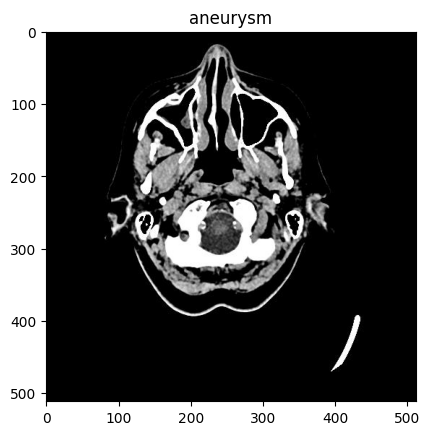

In [3]:
img = cv2.imread("/content/files/aneurysm/14.jpg")
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')
plt.show()

##**EDA**

## **Load the CSV**

In [5]:
dataset_dir = "/content/files"
csv_path = os.path.join(dataset_dir, "ct-brains-augmented.csv")

data_frame = pd.read_csv(csv_path)

data_frame.head()


jpg      type
0   aneurysm/0.jpg  aneurysm
1   aneurysm/1.jpg  aneurysm
2  aneurysm/10.jpg  aneurysm
3  aneurysm/11.jpg  aneurysm
4  aneurysm/12.jpg  aneurysm

In [6]:
data_frame.shape

(2590, 2)

In [8]:
image_paths = data_frame["jpg"].tolist()
labels = data_frame["type"].tolist()
image_paths

['aneurysm/0.jpg',
 'aneurysm/1.jpg',
 'aneurysm/10.jpg',
 'aneurysm/11.jpg',
 'aneurysm/12.jpg',
 'aneurysm/13.jpg',
 'aneurysm/14.jpg',
 'aneurysm/15.jpg',
 'aneurysm/16.jpg',
 'aneurysm/17.jpg',
 'aneurysm/18.jpg',
 'aneurysm/19.jpg',
 'aneurysm/2.jpg',
 'aneurysm/20.jpg',
 'aneurysm/21.jpg',
 'aneurysm/22.jpg',
 'aneurysm/23.jpg',
 'aneurysm/24.jpg',
 'aneurysm/25.jpg',
 'aneurysm/26.jpg',
 'aneurysm/27.jpg',
 'aneurysm/28.jpg',
 'aneurysm/29.jpg',
 'aneurysm/3.jpg',
 'aneurysm/30.jpg',
 'aneurysm/31.jpg',
 'aneurysm/32.jpg',
 'aneurysm/33.jpg',
 'aneurysm/34.jpg',
 'aneurysm/35.jpg',
 'aneurysm/36.jpg',
 'aneurysm/37.jpg',
 'aneurysm/38.jpg',
 'aneurysm/39.jpg',
 'aneurysm/4.jpg',
 'aneurysm/40.jpg',
 'aneurysm/41.jpg',
 'aneurysm/42.jpg',
 'aneurysm/43.jpg',
 'aneurysm/44.jpg',
 'aneurysm/45.jpg',
 'aneurysm/46.jpg',
 'aneurysm/47.jpg',
 'aneurysm/48.jpg',
 'aneurysm/49.jpg',
 'aneurysm/5.jpg',
 'aneurysm/50.jpg',
 'aneurysm/51.jpg',
 'aneurysm/52.jpg',
 'aneurysm/53.jpg',
 'aneu

**Display Sample Images**

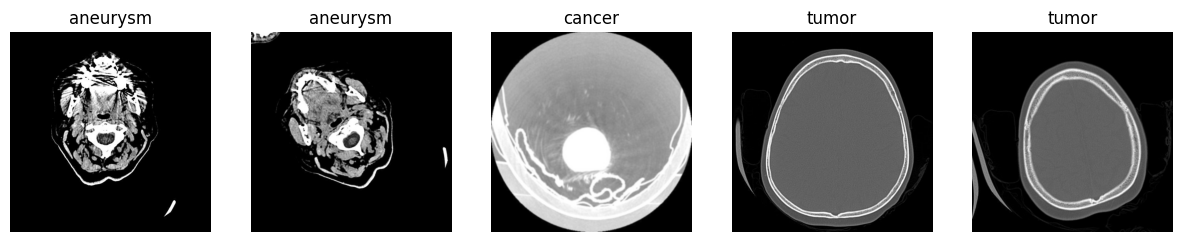

In [9]:
num_samples = 5
step = 600

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
  idx = i * step   # skip images by step size

  # safety check to avoid index errors
  if idx >= len(image_paths):
      print(f"Index {idx} out of range (len = {len(image_paths)}). Stopping.")
      break

  img_path = os.path.join('/content/files',
                          image_paths[idx])

  # read image (returns BGR for color, single channel for grayscale)
  img = cv2.imread(img_path)

  if img is None:
      print(f"Error loading image: {img_path}")
      continue


  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(str(labels[idx]))
  axes[i].axis('off')

plt.show()


**Class Distribution Plot**

In [10]:
class_counts = pd.Series(labels).value_counts()
class_counts

cancer      910
aneurysm    840
tumor       840
Name: count, dtype: int64

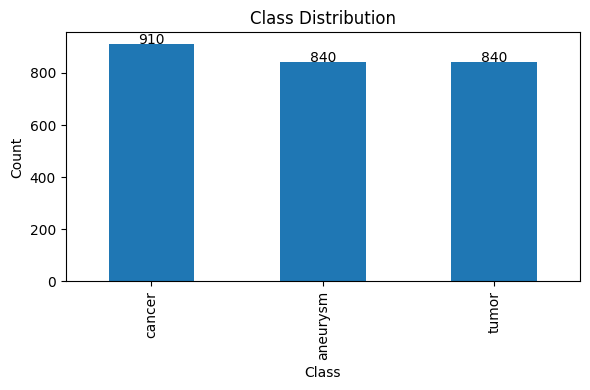

In [11]:
plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar")

plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")

# add counts on bars

for i, val in enumerate(class_counts):
  plt.text(i, val + 0.5, str(val), ha="center")

plt.tight_layout()
plt.show()


**Visualize Image Stats**

In [12]:
images = []

for file_name in image_paths:
  img_path = os.path.join(dataset_dir, file_name)
  img = cv2.imread(img_path)
  if img is not None:
    images.append(img)
  else:
    print(f"Warning: Failed to load {file_name}")


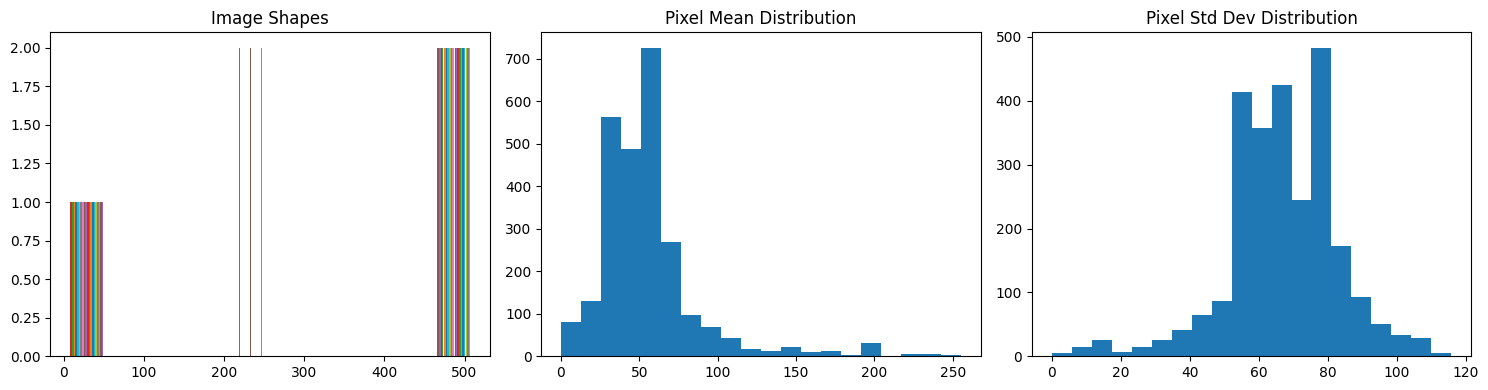

In [13]:
shapes = [img.shape for img in images]
means = [np.mean(img) for img in images]
stds = [np.std(img) for img in images]

plt.figure(figsize=(15, 4))

# Shapes

plt.subplot(1, 3, 1)
# plt.hist([str(s) for s in shapes])
plt.hist(shapes)
plt.title("Image Shapes")
# plt.xticks(rotation=45)

# Means

plt.subplot(1, 3, 2)
plt.hist(means, bins=20)
plt.title("Pixel Mean Distribution")

# Standard deviations

plt.subplot(1, 3, 3)
plt.hist(stds, bins=20)
plt.title("Pixel Std Dev Distribution")

plt.tight_layout()
plt.show()


In [16]:
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array

data_dir = "/content/files"
image_size = (256, 256)
seed = 50

# Step 1: Load the full dataset (all 3 classes)
full_ds = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    batch_size=None,
    shuffle=True,
    seed=seed
)


Found 2590 files belonging to 3 classes.


In [17]:
# Step 2: Calculate dataset sizes
import tensorflow as tf
num_samples =tf.data.experimental.cardinality(full_ds).numpy()
train_samples = int(num_samples * 0.6)
val_samples = int(num_samples * 0.1)
test_samples = num_samples - train_samples - val_samples

num_samples,train_samples,val_samples,test_samples

(np.int64(2590), 1554, 259, np.int64(777))

In [18]:
batch_size =32

In [19]:
# Step 3: Split dataset
train_ds = full_ds.take(train_samples).batch(batch_size, drop_remainder=True)
val_ds   = full_ds.skip(train_samples).take(val_samples).batch(batch_size, drop_remainder=True)
test_ds  = full_ds.skip(train_samples + val_samples).take(test_samples).batch(batch_size, drop_remainder=True)

In [20]:
# Step 4: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Optional: Check

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 48
Validation batches: 8
Test batches: 24


In [22]:
class_names = full_ds.class_names
class_names

['aneurysm', 'cancer', 'tumor']

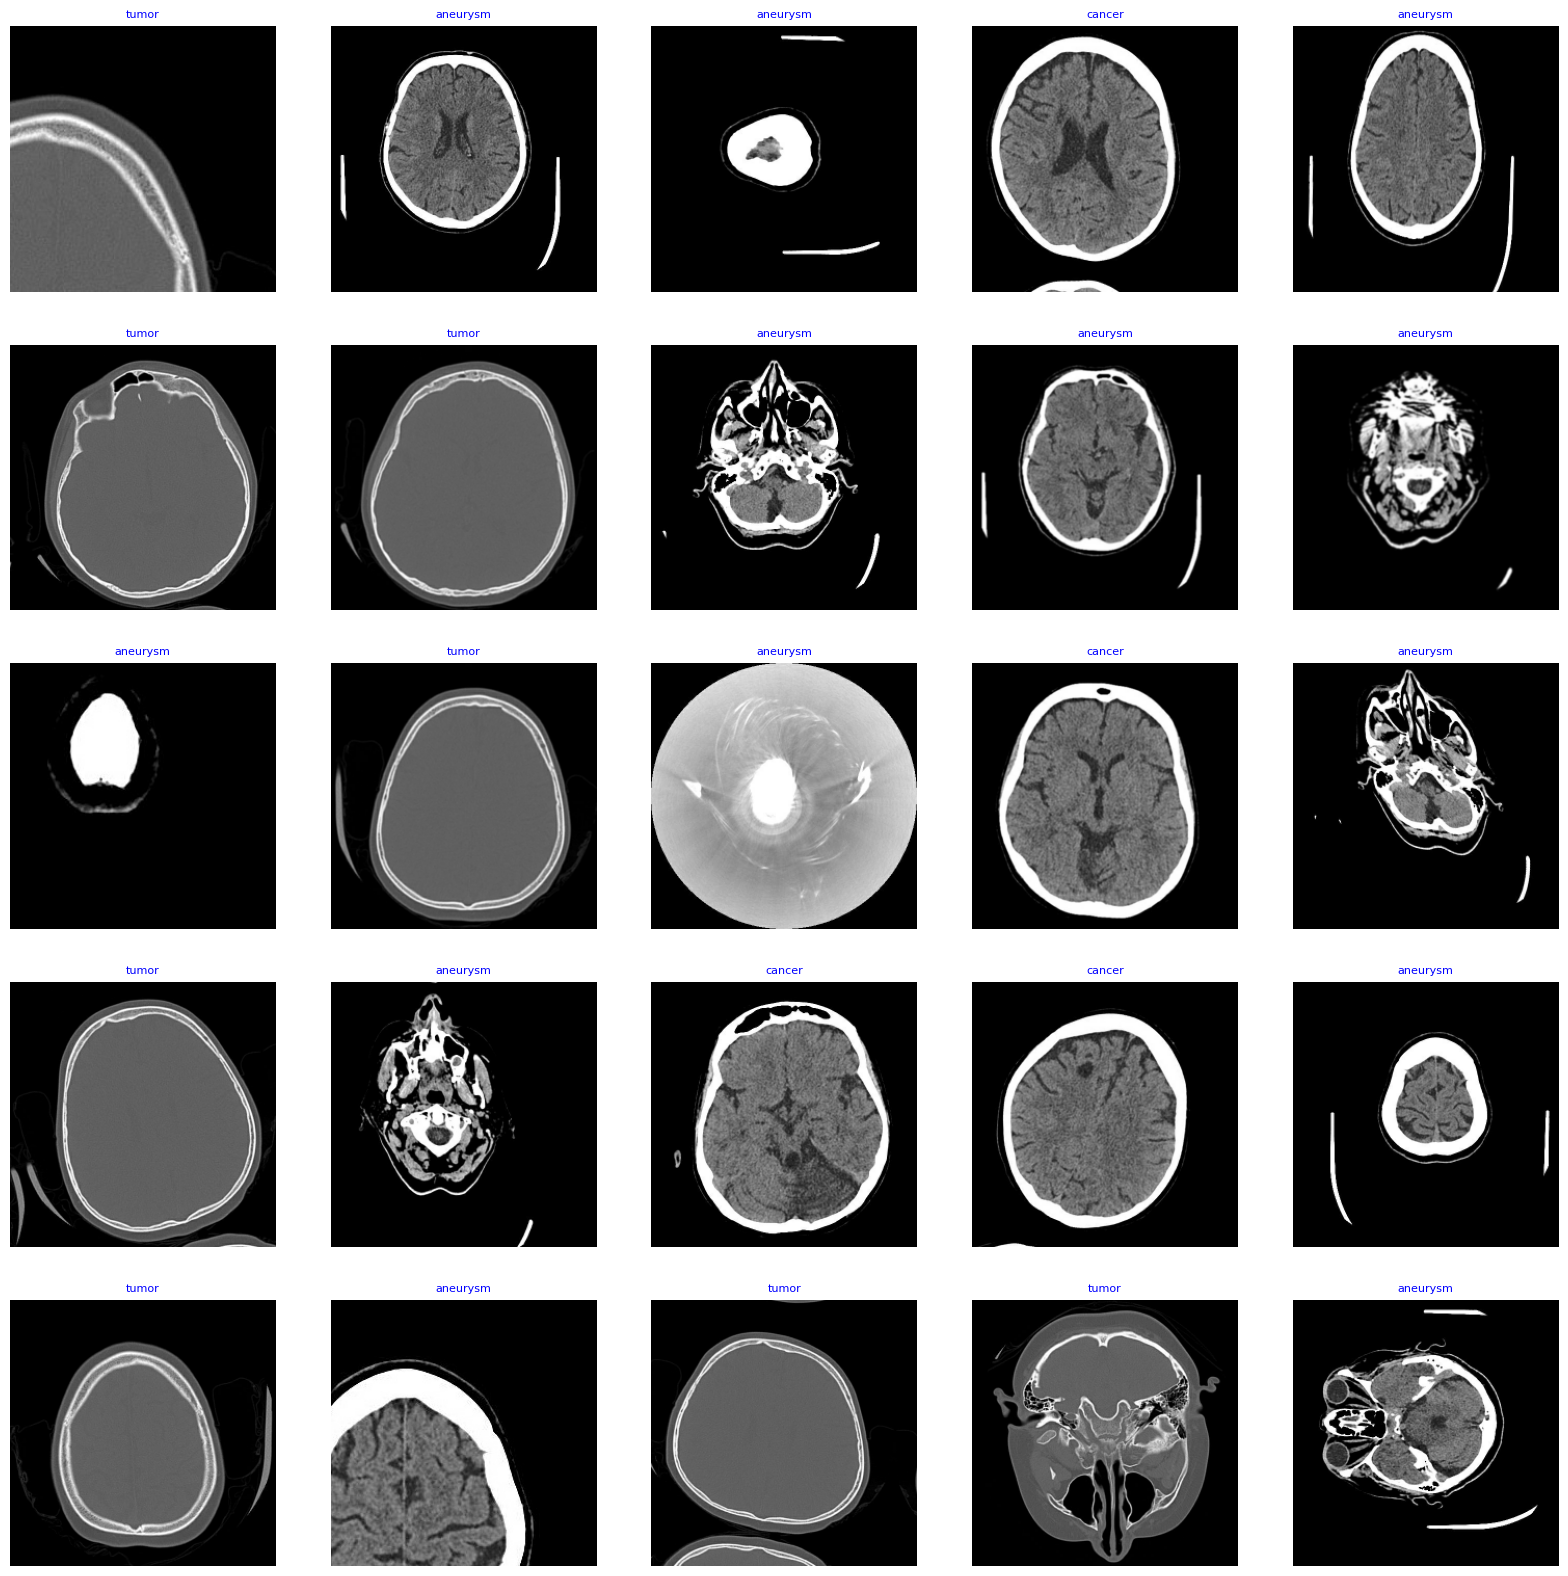

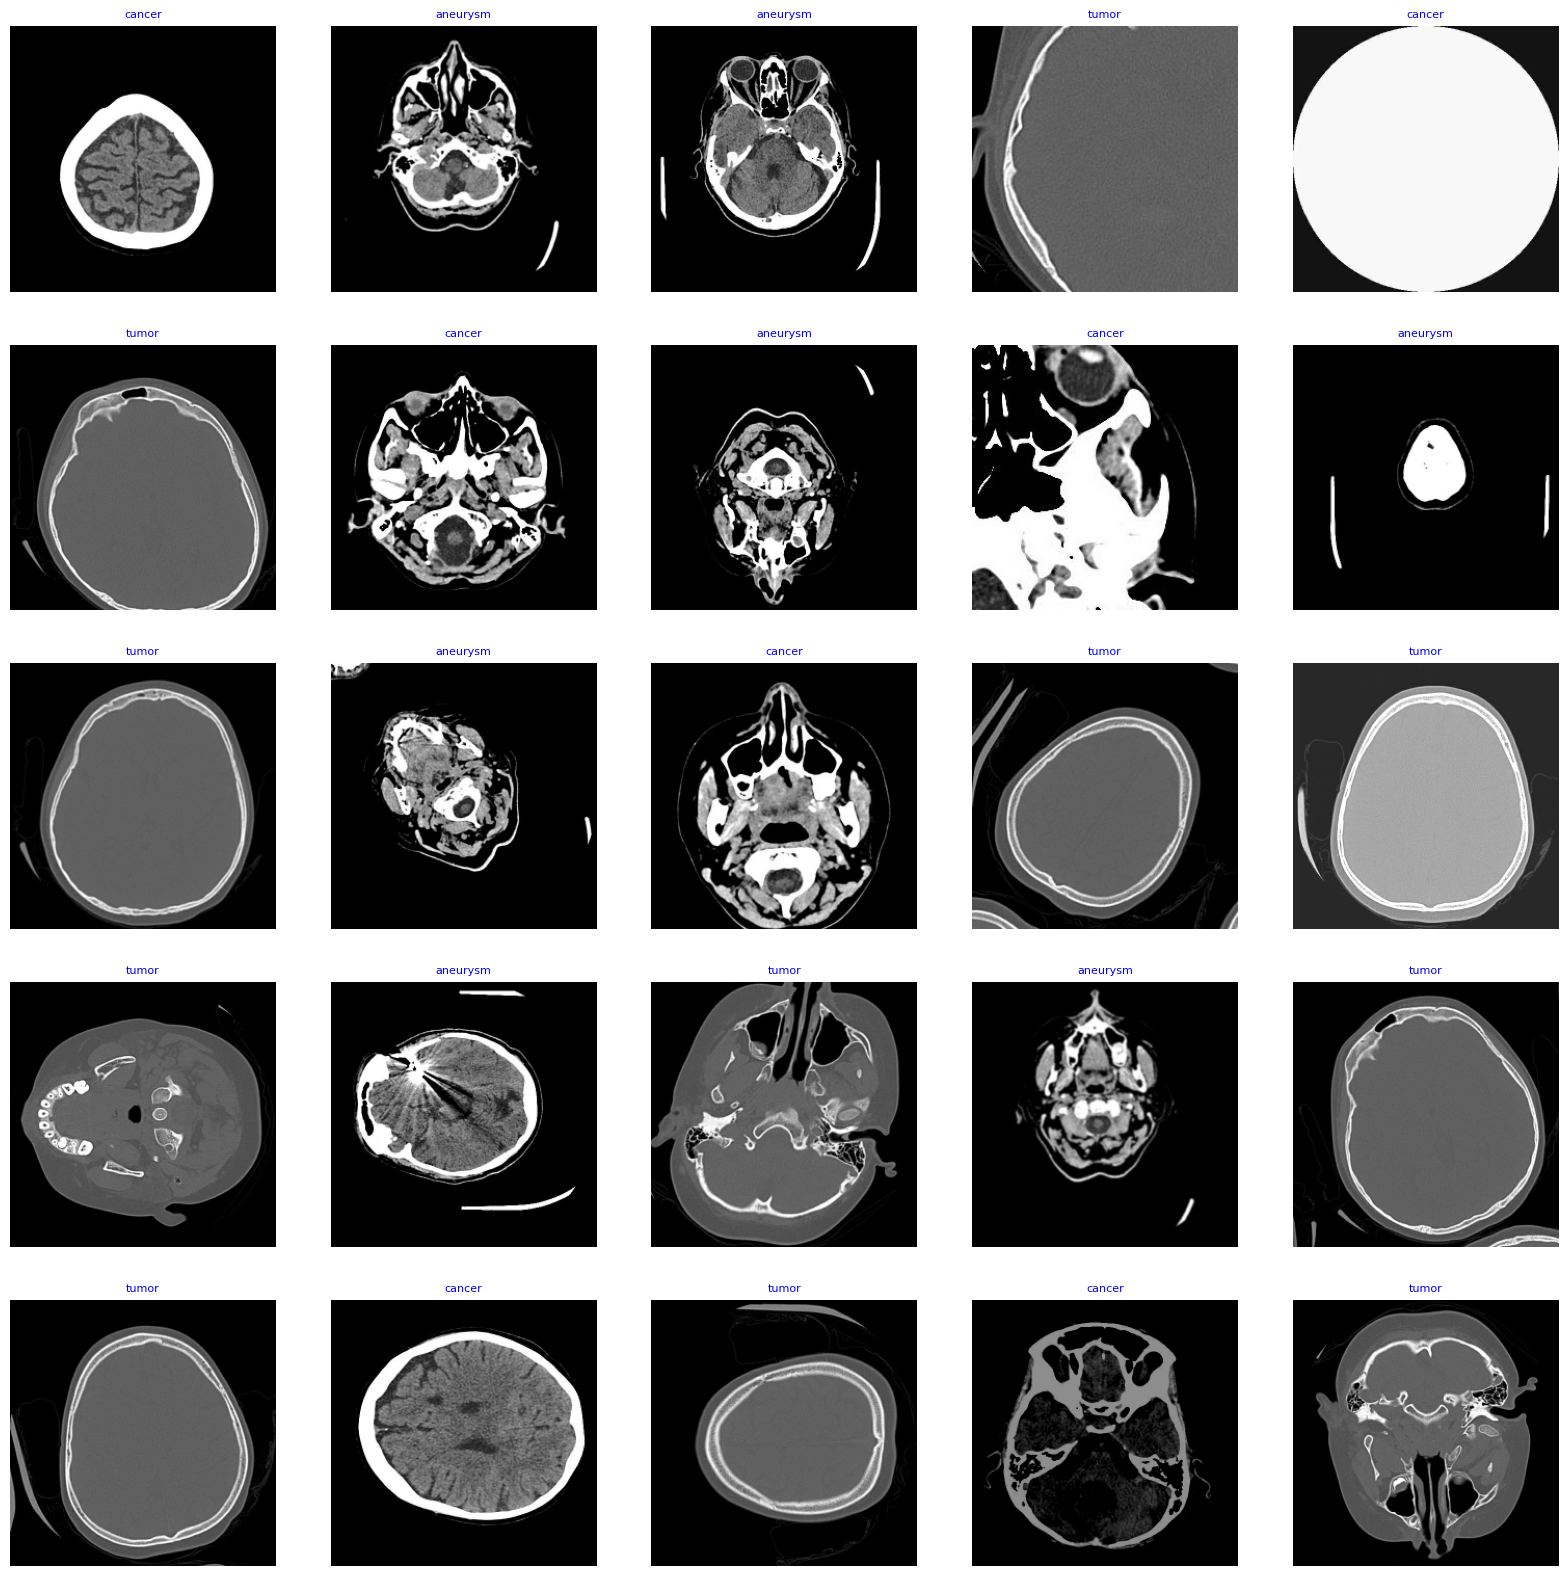

In [23]:
def show_images_ds(dataset, class_names):
    """
    Display a batch of images from a tf.data.Dataset
    """
    for images, labels in dataset.take(1):
        sample = min(len(labels), 25)
        plt.figure(figsize=(20, 20))
        for i in range(sample):
            plt.subplot(5, 5, i + 1)
            image = images[i].numpy().astype("uint8")
            plt.imshow(image)
            class_name = class_names[labels[i].numpy()]
            plt.title(class_name, color='blue', fontsize=8)
            plt.axis('off')
        plt.show()


show_images_ds(train_ds, full_ds.class_names)
show_images_ds(val_ds, full_ds.class_names)

In [33]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2
from keras.applications.vgg16 import VGG16

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = False

# Create a new model that includes the base_model
input_shape = (256, 256, 3)
vgg_model= tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(124, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(3, activation='softmax')
])



In [34]:
# Compile the model
vgg_model.compile(
    loss='SparseCategoricalCrossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy']
)
vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 124)            │        63,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124)            │           496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,207 (56.41 MB)

 Trainable params: 73,111 (285.59 KB)

 Non-trainable params: 14,715,096 (56.13 MB)

In [35]:
batch_size = 32  # set batch size for training
epochs = 50     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = tf.data.experimental.cardinality(train_ds).numpy()    # number of training batch to run per epoch

# callbacks = [MyCallback(vgg_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [36]:
batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
batches , val_batches

(np.int64(48), np.int64(8))

In [37]:
from tensorflow import keras
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [38]:
history = vgg_model.fit(
    train_ds,                   # training dataset
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping],  # callbacks
    validation_data=val_ds,     # validation dataset
    shuffle=False          # shuffle is already handled in the dataset

)


Epoch 1/50
48/48 - 19s - 400ms/step - accuracy: 0.3665 - loss: 1.7354 - val_accuracy: 0.5508 - val_loss: 1.0295
Epoch 2/50
48/48 - 15s - 312ms/step - accuracy: 0.4271 - loss: 1.4959 - val_accuracy: 0.6250 - val_loss: 0.8940
Epoch 3/50
48/48 - 14s - 291ms/step - accuracy: 0.4701 - loss: 1.3209 - val_accuracy: 0.6016 - val_loss: 0.9625
Epoch 4/50
48/48 - 14s - 298ms/step - accuracy: 0.5026 - loss: 1.2644 - val_accuracy: 0.6133 - val_loss: 0.8539
Epoch 5/50
48/48 - 14s - 300ms/step - accuracy: 0.5234 - loss: 1.1549 - val_accuracy: 0.7617 - val_loss: 0.6633
Epoch 6/50
48/48 - 14s - 294ms/step - accuracy: 0.5671 - loss: 1.0539 - val_accuracy: 0.7070 - val_loss: 0.7258
Epoch 7/50
48/48 - 15s - 306ms/step - accuracy: 0.5430 - loss: 1.1348 - val_accuracy: 0.7227 - val_loss: 0.6537
Epoch 8/50
48/48 - 14s - 299ms/step - accuracy: 0.5775 - loss: 1.0340 - val_accuracy: 0.7695 - val_loss: 0.6315
Epoch 9/50
48/48 - 14s - 293ms/step - accuracy: 0.5768 - loss: 1.0652 - val_accuracy: 0.7773 - val_loss:

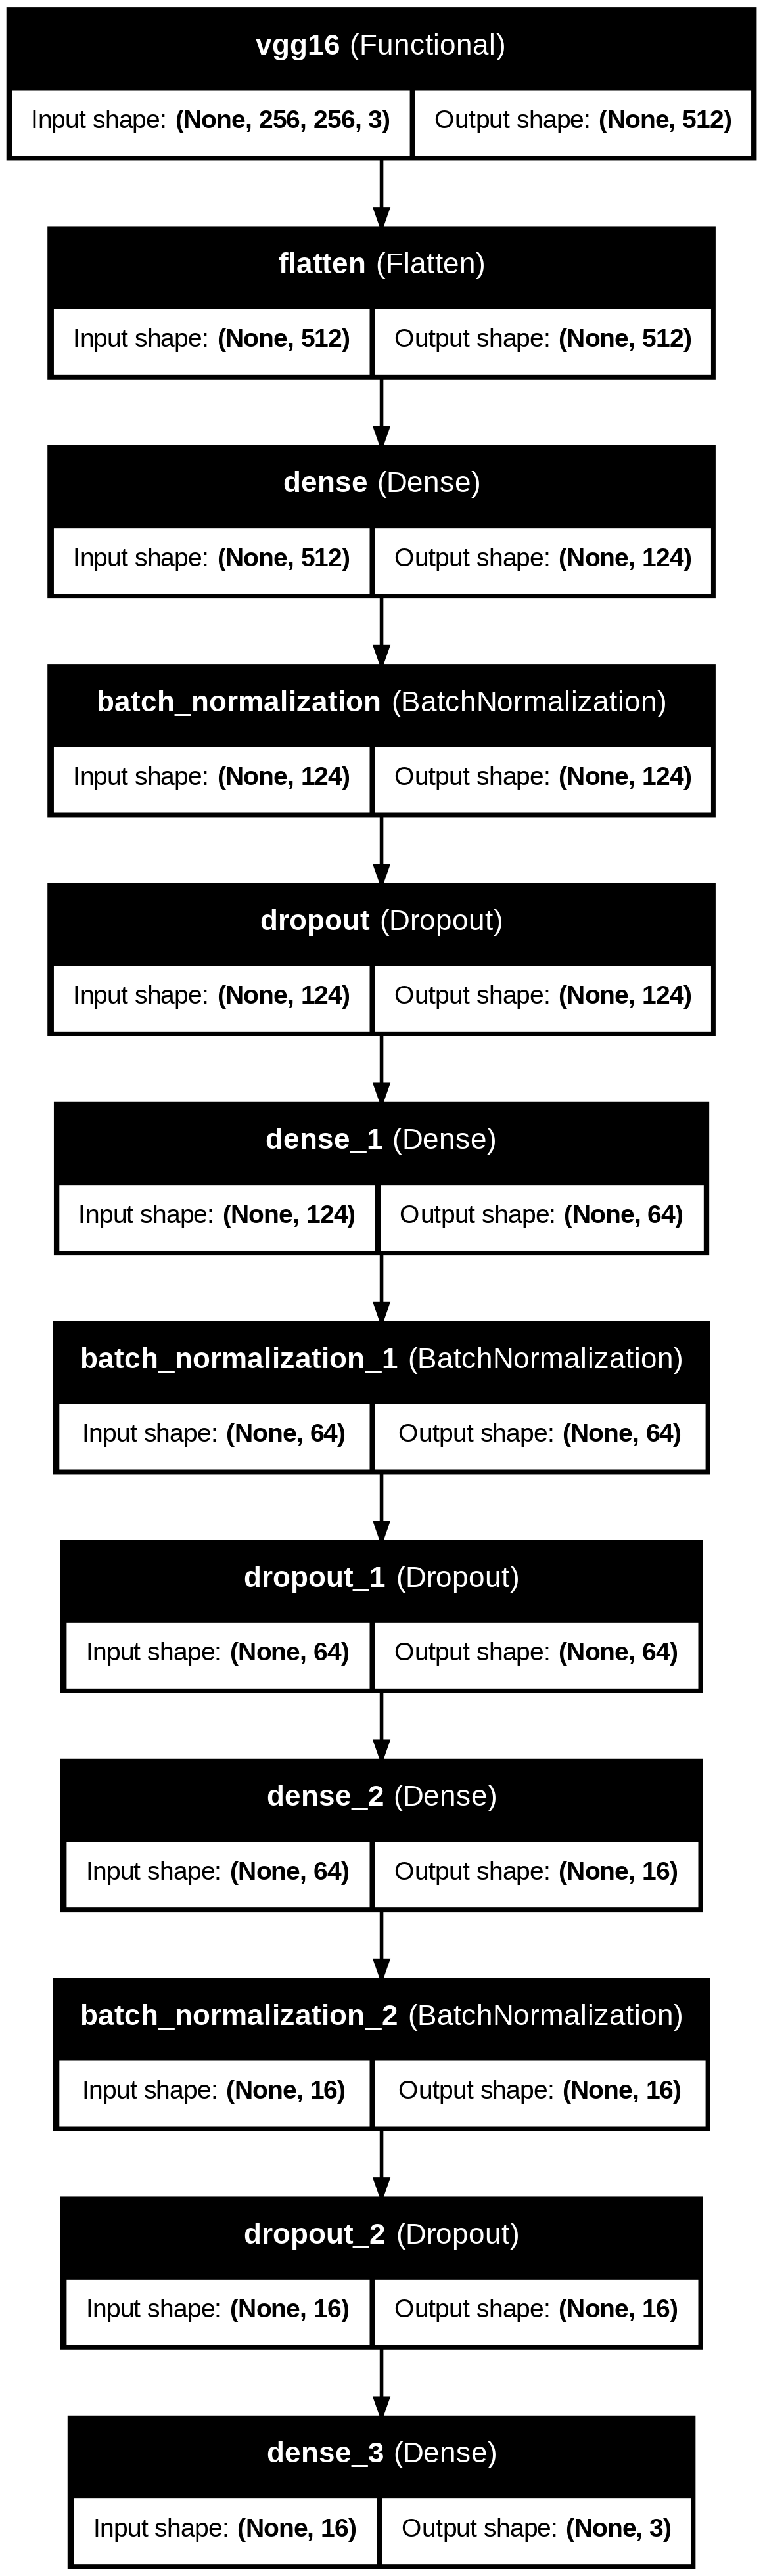

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(vgg_model, to_file='VGG16_model_architecture.png', show_shapes=True, show_layer_names=True)

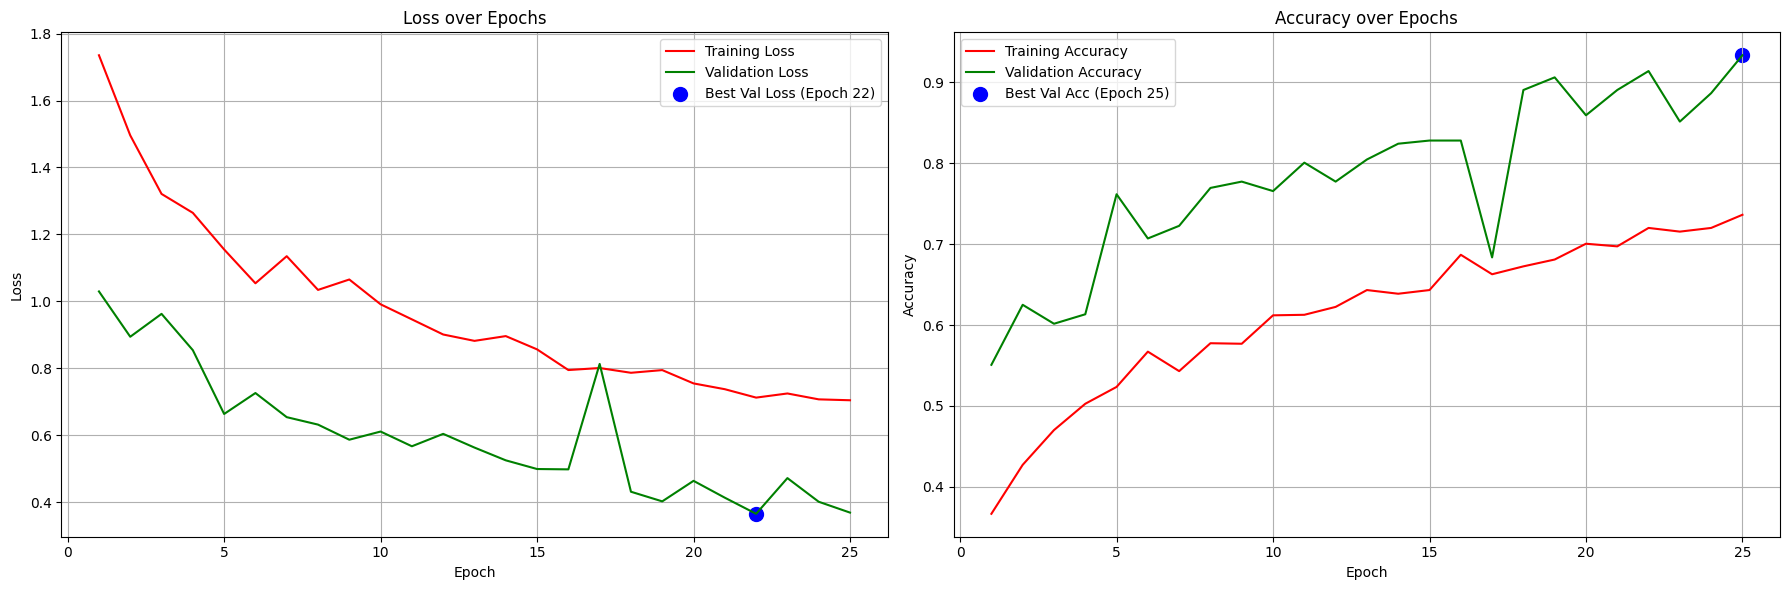

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    # Extract metrics from history
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Find best epochs
    best_loss_epoch = np.argmin(val_loss)
    best_acc_epoch = np.argmax(val_acc)

    # Epoch numbers
    epochs = np.arange(1, len(tr_acc)+1)

    # Plot Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='green')
    plt.scatter(best_loss_epoch+1, val_loss[best_loss_epoch], color='blue', s=100,
                label=f'Best Val Loss (Epoch {best_loss_epoch+1})')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_acc, label='Training Accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
    plt.scatter(best_acc_epoch+1, val_acc[best_acc_epoch], color='blue', s=100,
                label=f'Best Val Acc (Epoch {best_acc_epoch+1})')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training(history)


In [50]:
vgg_model.save("vgg_model.keras")

# **ResNet50**

In [46]:
import os
import random
import shutil
from math import floor

# Source dataset directory with class subfolders
source_dir = "/content/files"

# Destination for test split
test_dir = "/content/test"
os.makedirs(test_dir, exist_ok=True)

random.seed(42)

all_images = []

# Step 1: Collect all image paths with class information
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for img in os.listdir(class_path):
        if img.lower().endswith((".jpg", ".jpeg", ".png")):
            all_images.append((class_name, img))

# Step 2: Compute 10% of total images
total = len(all_images)
k = floor(0.15 * total)

print(f"Total images: {total}")
print(f"Selecting {k} images (15%) for test dataset...")

# Step 3: Randomly choose 15%
selected = random.sample(all_images, k)

# Step 4: Move images into test/class_name/ folders
for class_name, img in selected:
    src = os.path.join(source_dir, class_name, img)

    class_dest_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dest_dir, exist_ok=True)

    dst = os.path.join(class_dest_dir, img)

    shutil.move(src, dst)

print("\nTest dataset created successfully!")


Total images: 2590
Selecting 388 images (15%) for test dataset...

Test dataset created successfully!


In [47]:
import tensorflow as tf


In [55]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/files',
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,                     # must be used in both calls to ensure consistency.
    validation_split=0.20,
    subset="training"            # Add subset argument to prevent train/validation data duplication
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/files',
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,         # must be used in both calls to ensure consistency.
    validation_split=0.20,
    subset="validation"
)


Found 2202 files belonging to 3 classes.
Using 1762 files for training.
Found 2202 files belonging to 3 classes.
Using 440 files for validation.


In [56]:
from keras.applications.resnet50 import preprocess_input
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

validation_ds = validation_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)


In [57]:
train_ds = train_ds.prefetch(AUTOTUNE)
validation_ds = validation_ds.prefetch(AUTOTUNE)


###  Short usage summary

**`map(..., num_parallel_calls=tf.data.AUTOTUNE)`**

> *Parallelizes data preprocessing*

* Applies transformations (resize, normalize, preprocess) using multiple CPU threads
* Speeds up **how fast** each batch is prepared

```python
train_ds = train_ds.map(fn, num_parallel_calls=tf.data.AUTOTUNE)
```


**`prefetch(tf.data.AUTOTUNE)`**

> *Overlaps data loading with model training*

* Prepares the **next batch while the current batch is training**
* Prevents GPU/CPU idle time

```python
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
```



In [58]:
# from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.metrics import Precision, Recall, AUC
# from tensorflow.keras.regularizers import L1L2
# from keras.applications.resnet50 import ResNet50, preprocess_input

# tf.keras.backend.clear_session()

# # Load the ResNet50 model without the top (classification) layers
# input_shape=(224,224,3)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')




# # Freeze the pre-trained layers
# base_model.trainable = False


# # Create a new model that includes the base_model
# resnet_model= tf.keras.Sequential([
#     # tf.keras.layers.Lambda(preprocess_input, input_shape=(224,224,3)),
#     Input(shape=(224,224,3)),
#     base_model,
#     Dense(124, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     BatchNormalization(),
#     Dropout(0.2),

#     Dense(3, activation='softmax')
# ])

# # Compile the model
# resnet_model.compile(
#     loss='sparse_categorical_crossentropy',
#     # optimizer=tf.keras.optimizers.SGD(0.001),
#     optimizer = tf.keras.optimizers.Adam(0.001),
#     metrics=['accuracy']
# )
# resnet_model.summary()

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input

tf.keras.backend.clear_session()

# Input layer
input_tensor = Input(shape=(224, 224, 3))

# Preprocessing layer
x = preprocess_input(input_tensor)

# Base ResNet50 (no top layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max'   # Gives (None, 2048)
)

# Freeze weights
base_model.trainable = False

# Pass through ResNet backbone
x = base_model(x, training=False)

# Dense layers
x = Dense(124, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)

x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)

# Output layer
output_tensor = Dense(3, activation='softmax')(x)

# Build final model
resnet_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile
resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

resnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 124)       │    254,076 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 124)       │        496 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 124)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,000 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │         51 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,851,695 (90.99 MB)

 Trainable params: 263,575 (1.01 MB)

 Non-trainable params: 23,588,120 (89.98 MB)

In [60]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [61]:

history = resnet_model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=validation_ds,
    shuffle=False          # shuffle is already handled in the dataset
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 347ms/step - accuracy: 0.7441 - loss: 0.6803 - val_accuracy: 0.9568 - val_loss: 0.1683
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9386 - loss: 0.2256 - val_accuracy: 0.9659 - val_loss: 0.1309
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9549 - loss: 0.1817 - val_accuracy: 0.9705 - val_loss: 0.1184
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9675 - loss: 0.1448 - val_accuracy: 0.9705 - val_loss: 0.1202
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9713 - loss: 0.1269 - val_accuracy: 0.9659 - val_loss: 0.1248
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9731 - loss: 0.1237 - val_accuracy: 0.9614 - val_loss: 0.1321
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9799 - loss: 0.1143 - val_accuracy: 0.9636 - val_loss: 0.1248
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9642 - loss: 0.1209 - val_accuracy: 

In [62]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 712 files belonging to 3 classes.


In [35]:
# Get all true labels and predictions
import numpy as np
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


In [36]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
cm

array([[199,   9,   0],
       [ 13, 199,   2],
       [  2,   0, 184]])

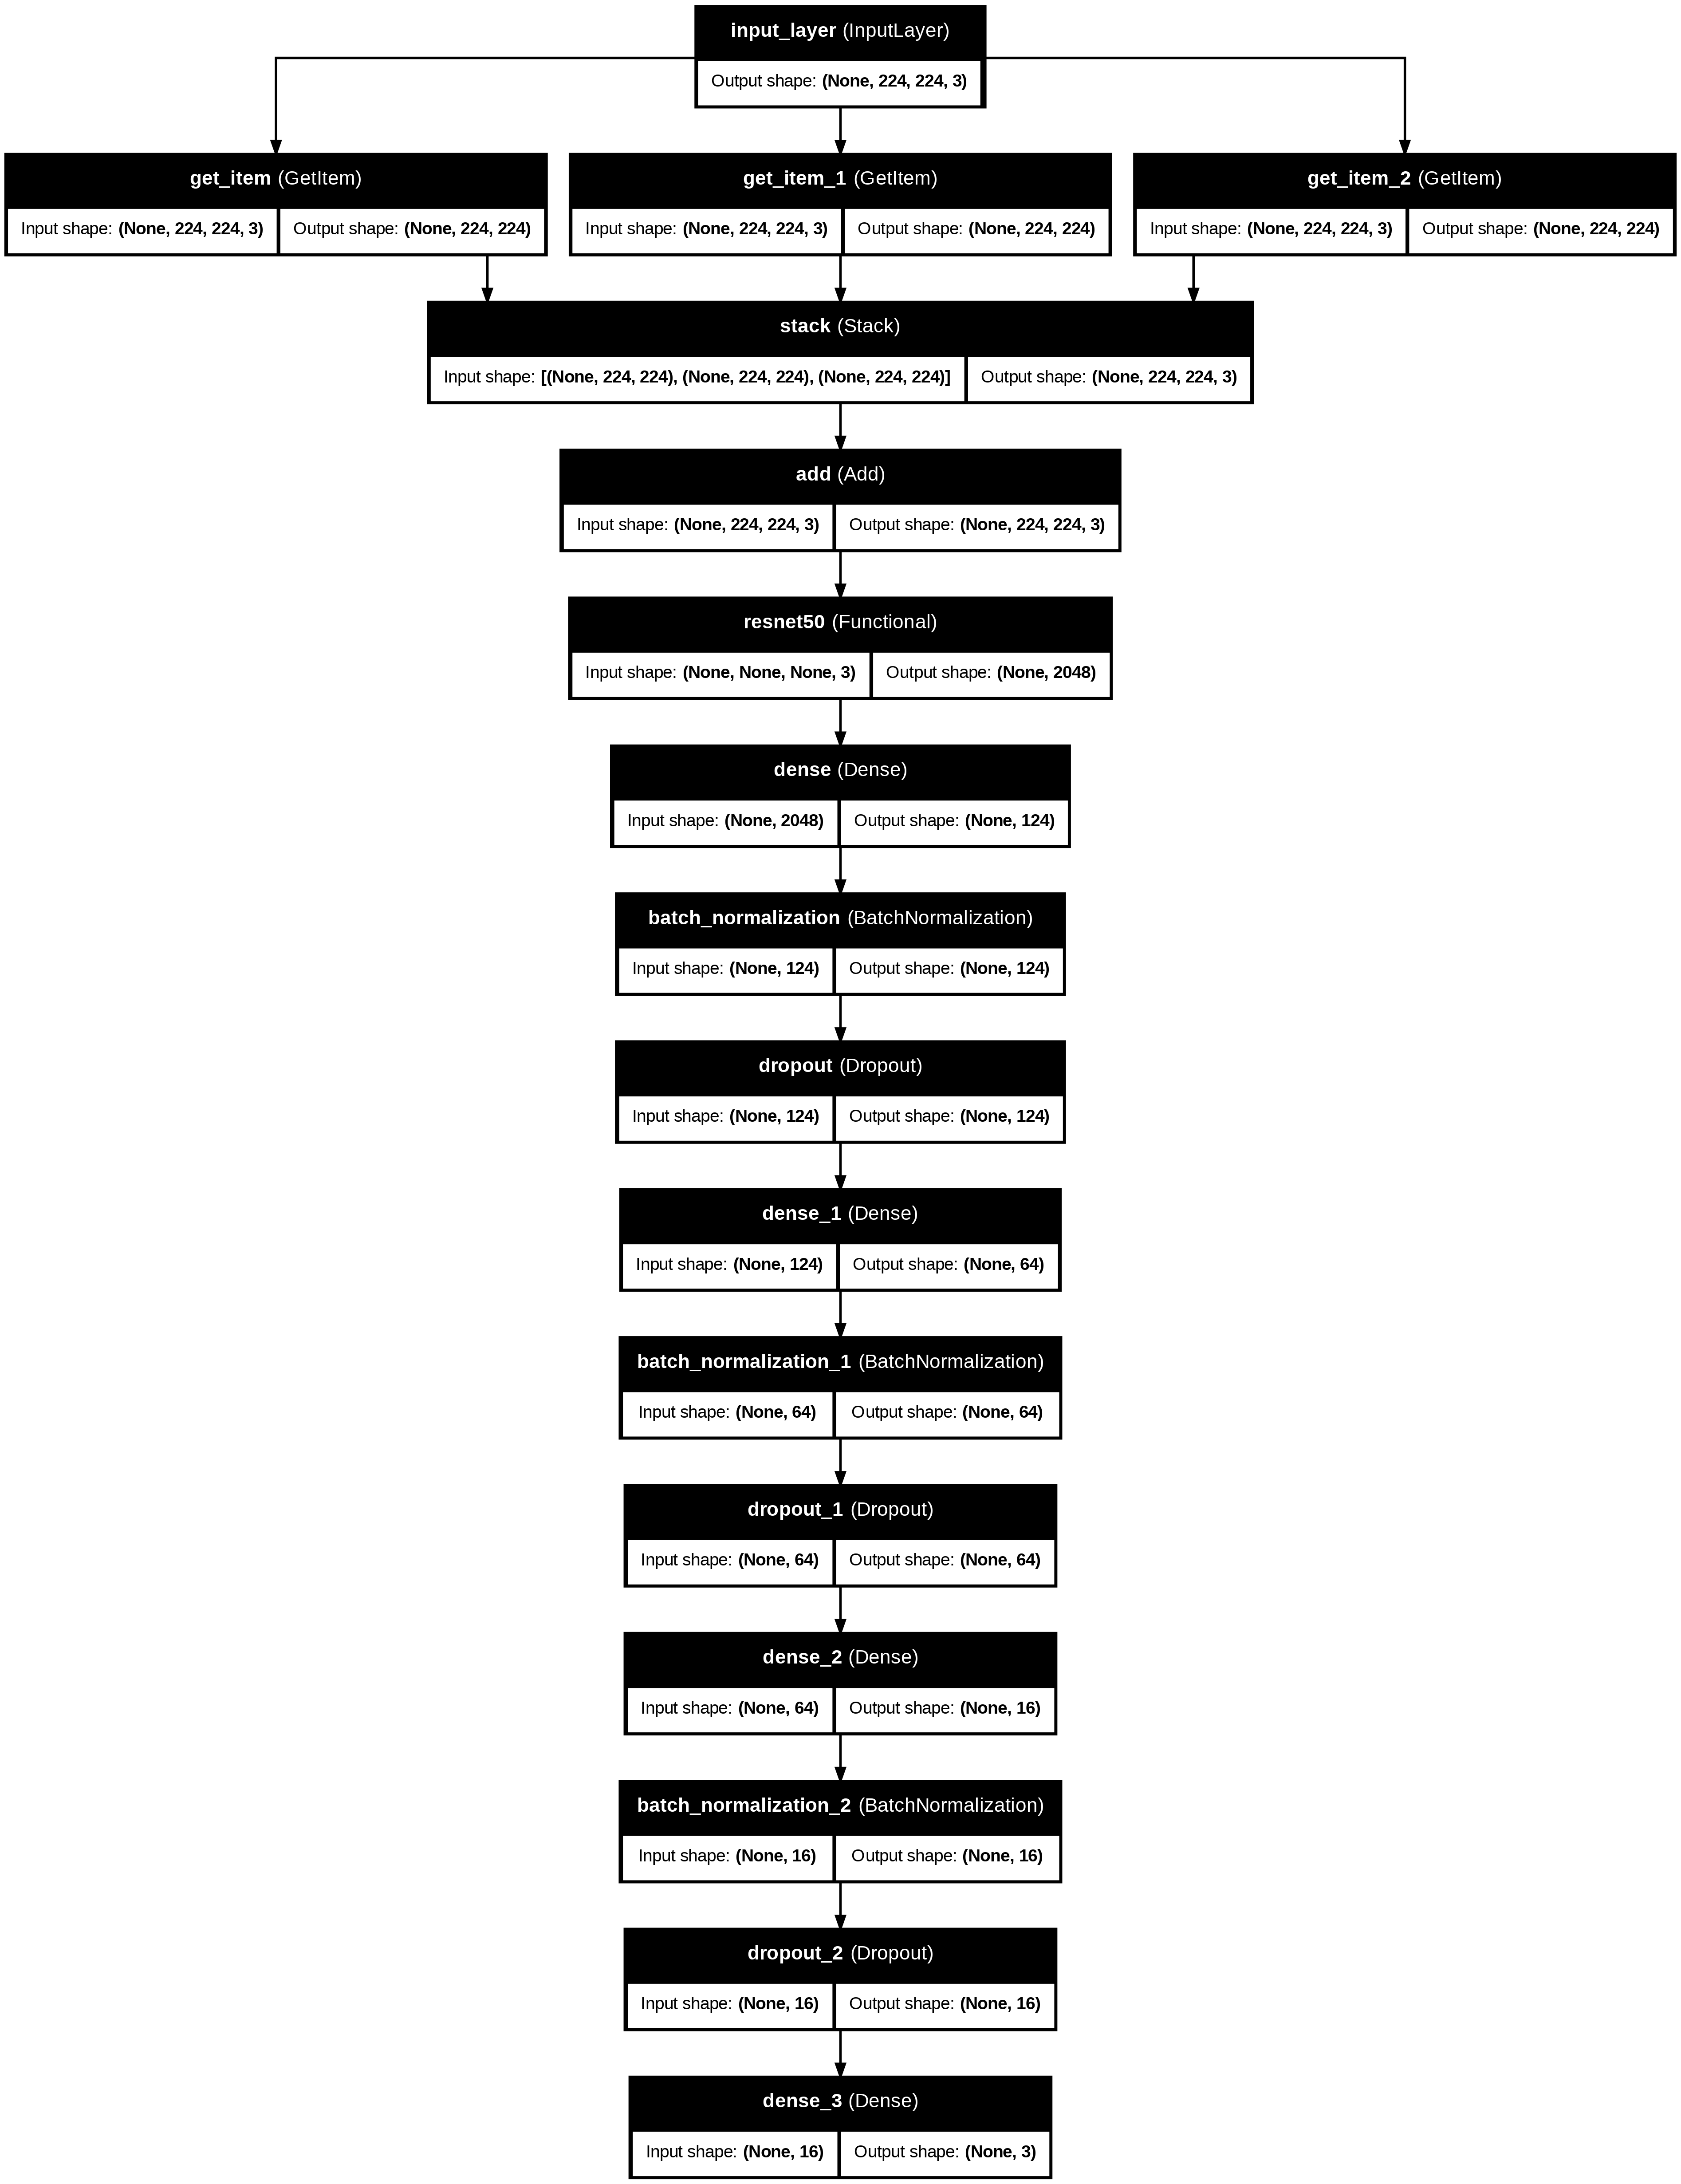

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model, to_file='resnet_model_architecture.png', show_shapes=True, show_layer_names=True)

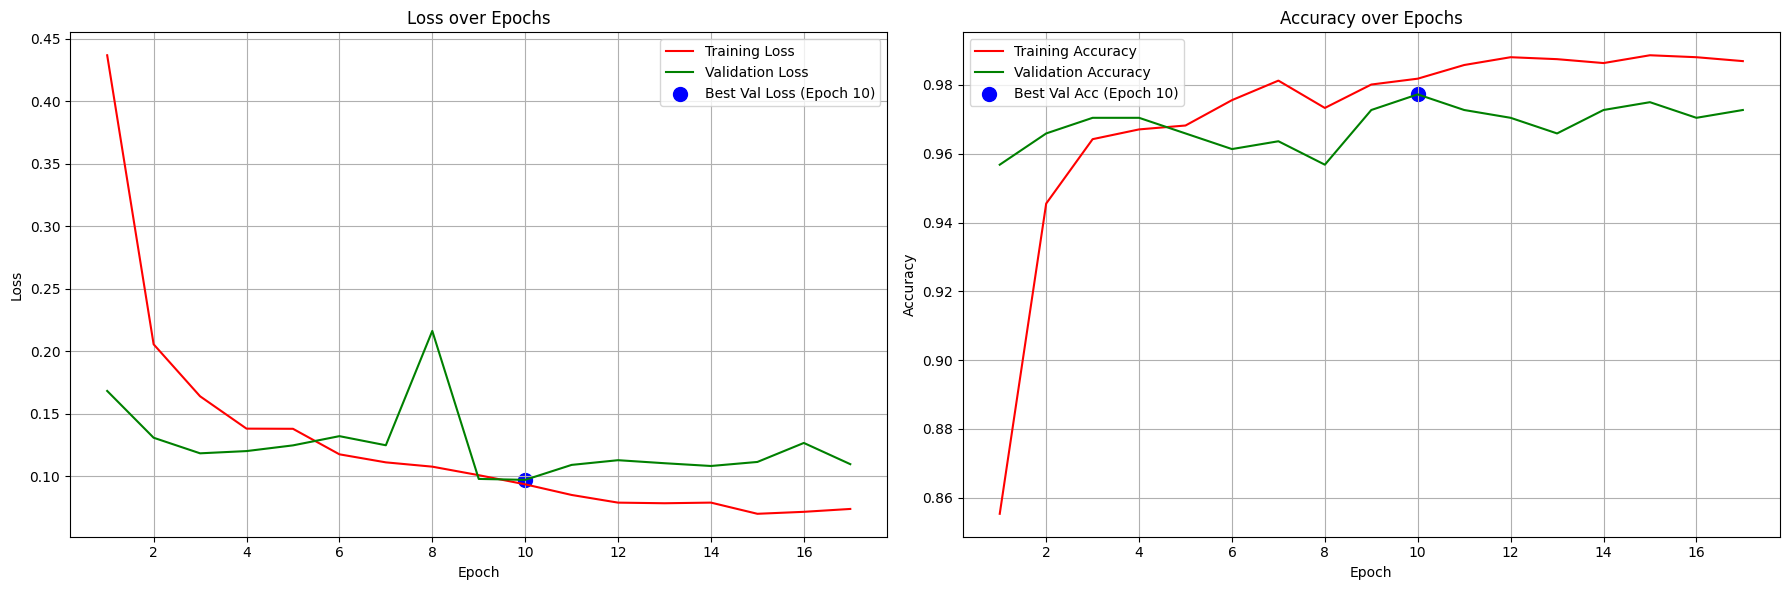

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    # Extract metrics from history
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Find best epochs
    best_loss_epoch = np.argmin(val_loss)
    best_acc_epoch = np.argmax(val_acc)

    # Epoch numbers
    epochs = np.arange(1, len(tr_acc)+1)

    # Plot Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='green')
    plt.scatter(best_loss_epoch+1, val_loss[best_loss_epoch], color='blue', s=100,
                label=f'Best Val Loss (Epoch {best_loss_epoch+1})')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_acc, label='Training Accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
    plt.scatter(best_acc_epoch+1, val_acc[best_acc_epoch], color='blue', s=100,
                label=f'Best Val Acc (Epoch {best_acc_epoch+1})')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training(history)


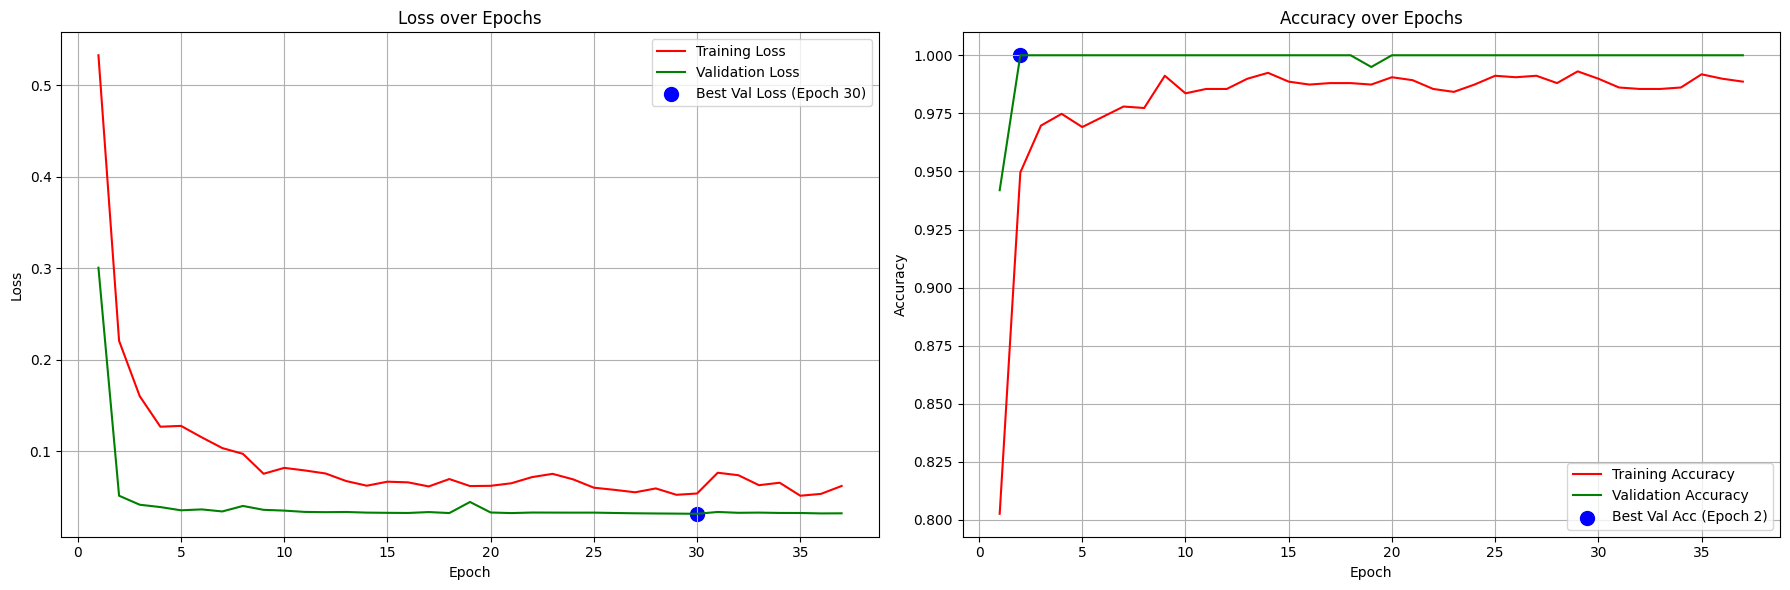

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_training(history):
#     # Extract metrics from history
#     tr_acc = history.history['accuracy']
#     tr_loss = history.history['loss']
#     val_acc = history.history['val_accuracy']
#     val_loss = history.history['val_loss']

#     # Find best epochs
#     best_loss_epoch = np.argmin(val_loss)
#     best_acc_epoch = np.argmax(val_acc)

#     # Epoch numbers
#     epochs = np.arange(1, len(tr_acc)+1)

#     # Plot Loss
#     plt.figure(figsize=(18,6))
#     plt.subplot(1,2,1)
#     plt.plot(epochs, tr_loss, label='Training Loss', color='red')
#     plt.plot(epochs, val_loss, label='Validation Loss', color='green')
#     plt.scatter(best_loss_epoch+1, val_loss[best_loss_epoch], color='blue', s=100,
#                 label=f'Best Val Loss (Epoch {best_loss_epoch+1})')
#     plt.title('Loss over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)

#     # Plot Accuracy
#     plt.subplot(1,2,2)
#     plt.plot(epochs, tr_acc, label='Training Accuracy', color='red')
#     plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
#     plt.scatter(best_acc_epoch+1, val_acc[best_acc_epoch], color='blue', s=100,
#                 label=f'Best Val Acc (Epoch {best_acc_epoch+1})')
#     plt.title('Accuracy over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# # Call the function
# plot_training(history)


In [39]:
resnet_model.save("resnet_model2.keras")

In [40]:
resnet_model.save("resnet_model.h5")

In [41]:
#Training set Accuracy
test_loss, test_acc = resnet_model.evaluate(test_ds)
print('Training accuracy:', test_ds)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9559 - loss: 0.1756
Training accuracy: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [42]:
train_loss, train_acc = resnet_model.evaluate(train_ds)
print('Training accuracy:', train_ds)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9938 - loss: 0.0404
Training accuracy: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [43]:
history.history

{'accuracy': [0.8026481866836548,
  0.9495586156845093,
  0.9697352051734924,
  0.9747793078422546,
  0.9691046476364136,
  0.9735183119773865,
  0.9779319167137146,
  0.9773013591766357,
  0.9911727905273438,
  0.9836065769195557,
  0.9854981303215027,
  0.9854981303215027,
  0.9899117350578308,
  0.9924337863922119,
  0.9886506795883179,
  0.9873896837234497,
  0.9880201816558838,
  0.9880201816558838,
  0.9873896837234497,
  0.9905422329902649,
  0.9892812371253967,
  0.9854981303215027,
  0.9842370748519897,
  0.9873896837234497,
  0.9911727905273438,
  0.9905422329902649,
  0.9911727905273438,
  0.9880201816558838,
  0.993064284324646,
  0.9899117350578308,
  0.9861286282539368,
  0.9854981303215027,
  0.9854981303215027,
  0.9861286282539368,
  0.9918032884597778,
  0.9899117350578308,
  0.9886506795883179],
 'loss': [0.5327256321907043,
  0.2207046002149582,
  0.160188689827919,
  0.12680195271968842,
  0.12769778072834015,
  0.11523516476154327,
  0.1034601703286171,
  0.097142

In [44]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

In [ ]:
model = tf.keras.models.load_model('/content/resnet_model.keras')

Testing Image by Image

In [ ]:
%pip install pydicom

In [ ]:
import numpy as np
import cv2
import pydicom



In [ ]:
def load_image(path):
    if path.lower().endswith(".dcm"):
        dicom = pydicom.dcmread(path)
        img = dicom.pixel_array.astype(np.float32)

        # Normalize DICOM intensity to 0–255
        img = img - img.min()
        img = img / (img.max() + 1e-6)
        img = (img * 255).astype(np.uint8)

        # Convert grayscale → RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    else:
        img = cv2.imread(path)                 # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


In [ ]:
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size)


In [ ]:
from keras.applications.resnet50 import preprocess_input

def preprocess(img):
    img = img.astype(np.float32)
    img = preprocess_input(img)   # RGB → BGR + mean subtraction
    return img


In [ ]:
def add_batch(img):
    return np.expand_dims(img, axis=0)


In [ ]:
def predict_image(model, image_path):
    img = load_image(image_path)
    img = resize_image(img)
    img = preprocess(img)
    img = add_batch(img)

    preds = model.predict(img)
    print(preds)
    print(np.argmax(preds, axis=1))
    class_id = np.argmax(preds, axis=1)[0]
    print(class_id)
    confidence = preds[0][class_id]

    return class_id, confidence


In [ ]:
class_id, confidence = predict_image(
    model,
    "/content/files/tumor/62.jpg"
)

print("Predicted class:", class_id)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[[2.4107521e-05 2.2268443e-05 9.9995363e-01]]
[2]
2
Predicted class: 2
Confidence: 0.9999536


next

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB7
tf.keras.backend.clear_session()

tf.keras.backend.clear_session()

# Load the EfficientNetB7 model without the top (classification) layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = False
input_shape = (224, 224, 3)


# Create a new model that includes the base_model
efficientnet_model= tf.keras.Sequential([
    tf.keras.layers.Lambda(preprocess_input, input_shape=(224,224,3)),
    base_model,
    Dense(124, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])

# Compile the model
efficientnet_model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(0.001),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
efficientnet_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 124)            │       317,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124)            │           496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,425,158 (245.76 MB)

 Trainable params: 327,063 (1.25 MB)

 Non-trainable params: 64,098,095 (244.51 MB)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
history = efficientnet_model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=validation_ds,
    shuffle=False          # shuffle is already handled in the dataset
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.5164 - loss: 1.1551 - val_accuracy: 0.7455 - val_loss: 0.7574
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 0.7109 - loss: 0.7186 - val_accuracy: 0.8485 - val_loss: 0.6395
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step - accuracy: 0.7307 - loss: 0.6774 - val_accuracy: 0.8788 - val_loss: 0.3938
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 289ms/step - accuracy: 0.7852 - loss: 0.5560 - val_accuracy: 0.8636 - val_loss: 0.3794
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 279ms/step - accuracy: 0.7857 - loss: 0.5409 - val_accuracy: 0.8879 - val_loss: 0.2936
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - accuracy: 0.8247 - loss: 0.4789 - val_accuracy: 0.8939 - val_loss: 0.3065
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.8482 - loss: 0.4277 - val_accuracy: 0.8788 - val_loss: 0.3258
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.8414 - loss: 0.4403 - val_accura

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 388 files belonging to 3 classes.


In [ ]:
# Get all true labels and predictions
import numpy as np
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step


In [ ]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
cm

array([[  0,   0, 115],
       [  0,   0, 150],
       [  0,   0, 123]])

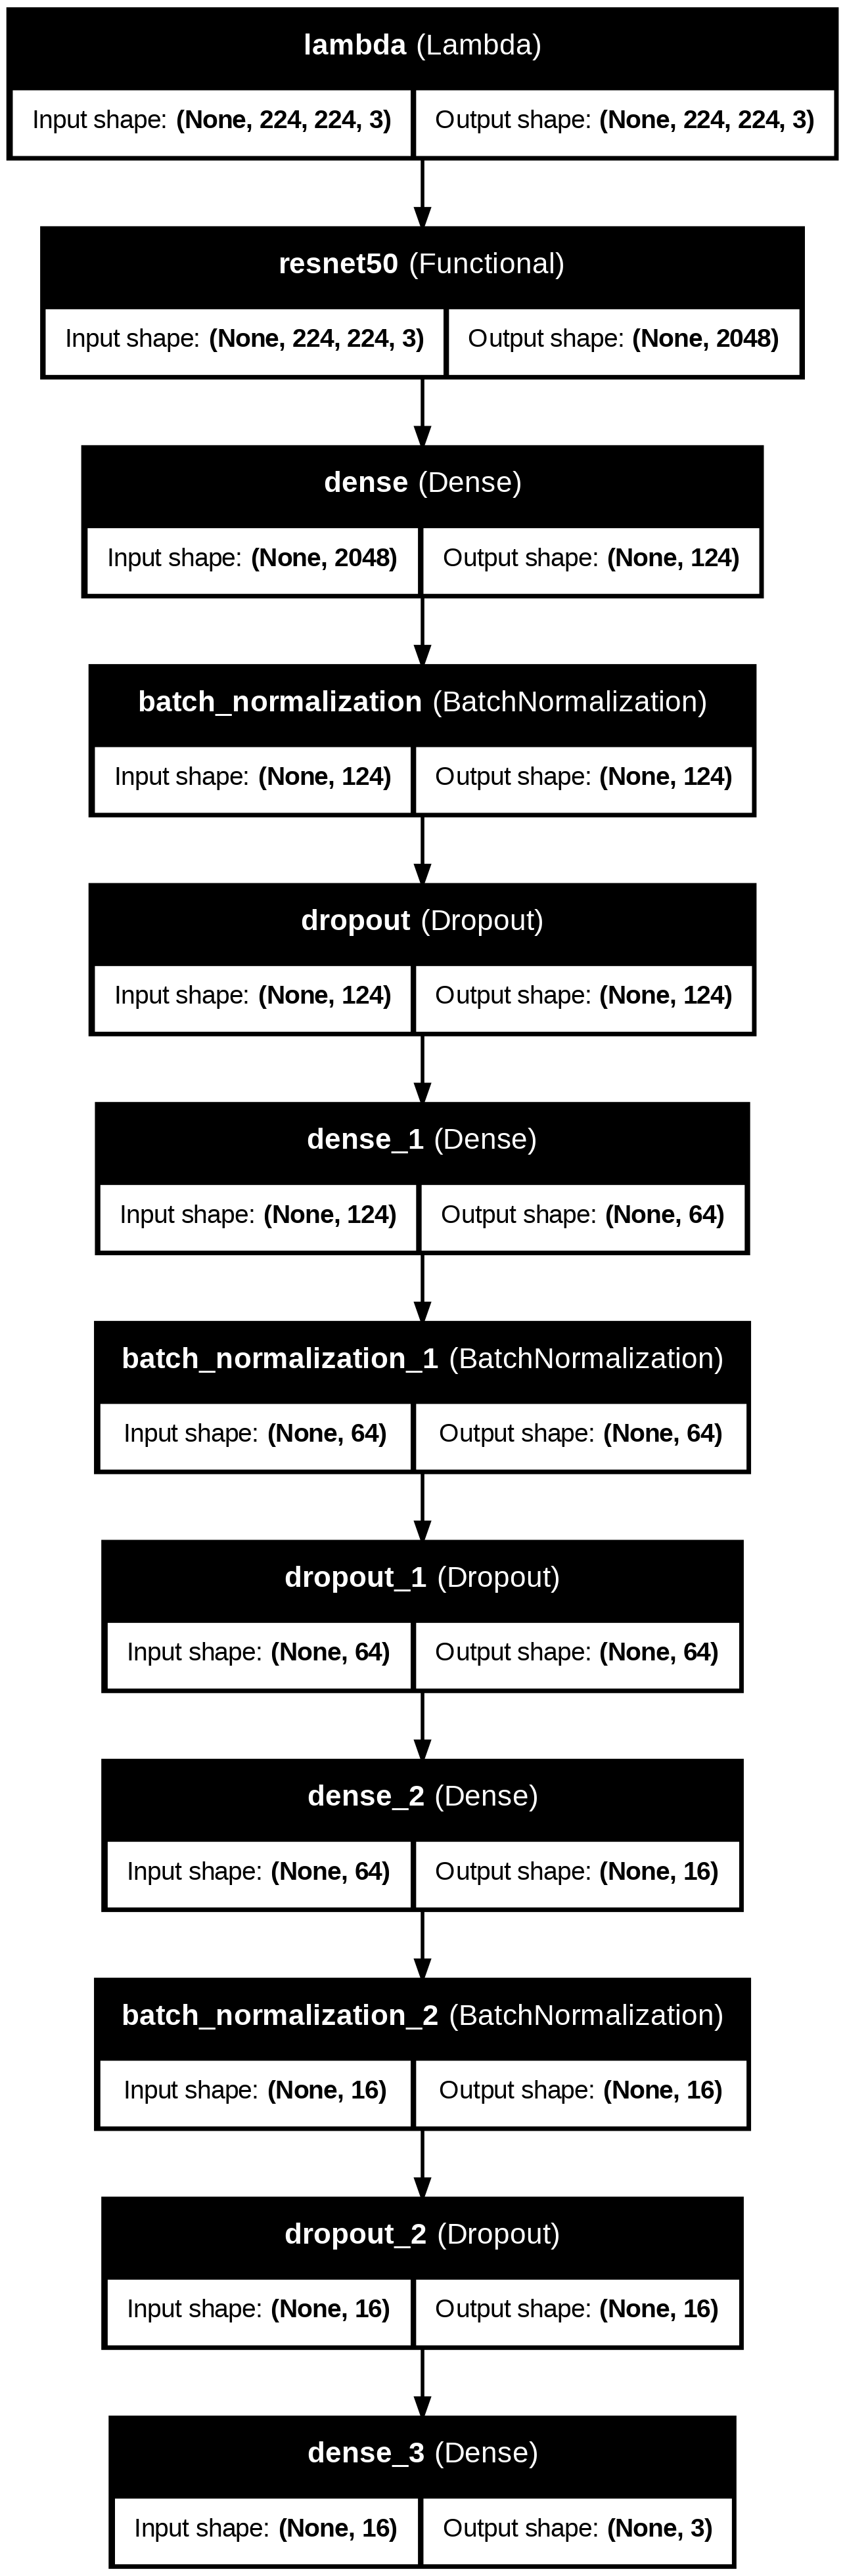

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model, to_file='VGG16_model_architecture.png', show_shapes=True, show_layer_names=True)

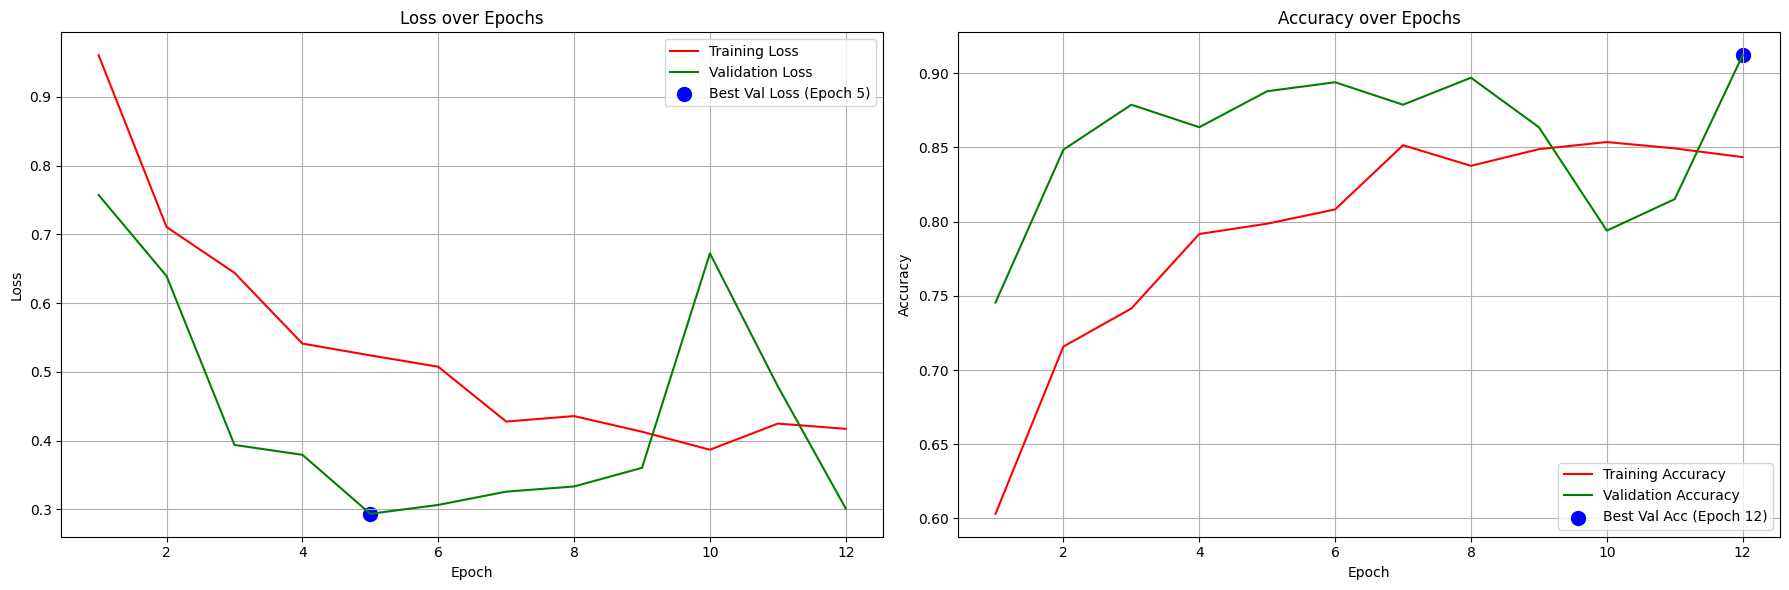

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    # Extract metrics from history
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Find best epochs
    best_loss_epoch = np.argmin(val_loss)
    best_acc_epoch = np.argmax(val_acc)

    # Epoch numbers
    epochs = np.arange(1, len(tr_acc)+1)

    # Plot Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='green')
    plt.scatter(best_loss_epoch+1, val_loss[best_loss_epoch], color='blue', s=100,
                label=f'Best Val Loss (Epoch {best_loss_epoch+1})')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_acc, label='Training Accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
    plt.scatter(best_acc_epoch+1, val_acc[best_acc_epoch], color='blue', s=100,
                label=f'Best Val Acc (Epoch {best_acc_epoch+1})')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training(history)
